In [1]:
# load instruct part data - images and corresponding masks

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [2]:
instructpart_train_dir = "/data/VLMGroundingProject/Datasets/InstructPart/train1800"
instructpart_test_dir = "/data/VLMGroundingProject/Datasets/InstructPart/test"

masks_dir = os.path.join(instructpart_test_dir, "masks")
images_dir = os.path.join(instructpart_test_dir, "images")
image_names = os.listdir(images_dir)
test_img_name = "45514228_f89388bda9_o-cabinet-handle.jpg"

In [ ]:
def load_mask_and_parse_name(image_name, masks_dir):
    """
    Load mask and extract object and part names from filename.
    
    Args:
        image_name: Name of the image file (with or without extension)
        masks_dir: Directory containing the mask files
    
    Returns:
        mask: Loaded mask as numpy array
        object_name: Name of the object
        part_name: Name of the part
    """
    #get basename
    basename = os.path.splitext(image_name)[0]
    
    # mask 
    mask_path = os.path.join(masks_dir, f"{basename}.png")
    mask = np.array(Image.open(mask_path))
    
    # parse the filename: image_id-object_name-part_name
    filename_parts = basename.split('-')
    part_name = filename_parts[-1]
    object_name = filename_parts[-2]

    return mask, object_name, part_name

In [4]:
def visualize_mask_on_image(image_name, images_dir, masks_dir):
    """
    Display an image with its mask overlay and show object/part names as title.
    
    Args:
        image_name: Name of the image file
        images_dir: Directory containing the images
        masks_dir: Directory containing the masks
    """
    basename = os.path.splitext(image_name)[0]
    
    # load image
    image_path = os.path.join(images_dir, image_name)
    image = Image.open(image_path)

    # load mask and object/part names
    mask, object_name, part_name = load_mask_and_parse_name(image_name, masks_dir)
    
    # figure
    plt.figure(figsize=(5, 4))
    plt.imshow(image)
    
    # overlay mask
    colored_mask = np.zeros((*mask.shape, 4))
    colored_mask[mask > 0] = [1, 0, 0, 0.5]  # Red with 50% transparency
    plt.imshow(colored_mask)
    
    # title
    plt.title(f"Object: {object_name} | Part: {part_name}", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


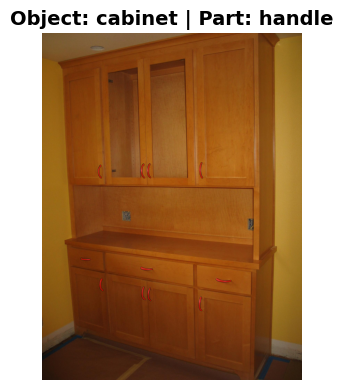

In [5]:
# 45514228_f89388bda9_o-cabinet-handle.jpg
visualize_mask_on_image(test_img_name, images_dir, masks_dir)

In [6]:
# since we can have multiple segmentations within the same image, we need to have a corresponding list of bboxes for multimodal LLM grounding 

In [7]:
# Get bboxes from from segments
from scipy import ndimage

def get_bboxes_from_mask(mask):
    """
    Extract bounding boxes for each connected component (segment) in the mask.
    
    Args:
        mask: Binary mask as numpy array
    
    Returns:
        bboxes: List of bounding boxes in format [x_min, y_min, x_max, y_max]
    """
    # connected components
    labeled_mask, num_segments = ndimage.label(mask > 0)
    
    bboxes = []
    
    # bounding box for each segment
    for segment_id in range(1, num_segments + 1):
        coords = np.argwhere(labeled_mask == segment_id)
        
        if len(coords) > 0:
            # min and max coords
            y_min, x_min = coords.min(axis=0)
            y_max, x_max = coords.max(axis=0)
            
            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
    
    return bboxes

In [8]:
def visualize_mask_with_bboxes(image_name, images_dir, masks_dir):
    """
    Display an image with mask overlay and bounding boxes around each segment.
    
    Args:
        image_name: Name of the image file
        images_dir: Directory containing the images
        masks_dir: Directory containing the masks
    """
    image_path = os.path.join(images_dir, image_name)
    image = Image.open(image_path)
    
    mask, object_name, part_name = load_mask_and_parse_name(image_name, masks_dir)
    
    bboxes = get_bboxes_from_mask(mask)
    
    # figure
    plt.figure(figsize=(5, 4))
    plt.imshow(image)
    
    # overlay 
    colored_mask = np.zeros((*mask.shape, 4))
    colored_mask[mask > 0] = [1, 0, 0, 0.5]  # Red with 50% transparency
    plt.imshow(colored_mask)

    # draw bboxes
    ax = plt.gca()
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        
        rect = plt.Rectangle((x_min, y_min), width, height, 
                            fill=False, edgecolor='yellow', linewidth=2)
        ax.add_patch(rect)
    
    plt.title(f"Object: {object_name} | Part: {part_name} | Segments: {len(bboxes)}", 
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return bboxes

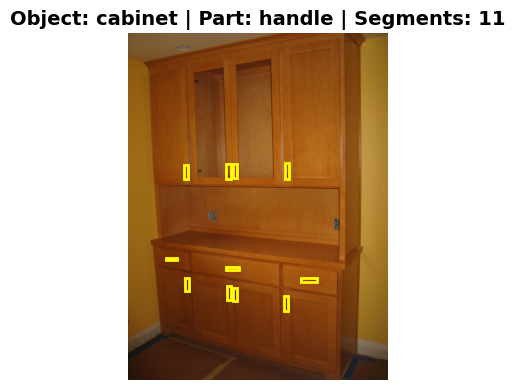

In [9]:
_ = visualize_mask_with_bboxes(test_img_name, images_dir, masks_dir)

In [10]:
# get points as well for each bbox
def get_bbox_midpoints(bboxes):
    """
    Compute the midpoint (center) of each bounding box.
    
    Args:
        bboxes: List of bounding boxes in format [x_min, y_min, x_max, y_max]
    
    Returns:
        midpoints: List of midpoints in format [x_center, y_center]
    """
    midpoints = []
    
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        midpoints.append([x_center, y_center])
    
    return midpoints

In [11]:
from scipy import ndimage

def get_deepest_points(m):
    """
    Find the deepest point inside each connected segment of the mask.
    
    Args:
        m: Binary mask array (may contain multiple disjoint segments)
    
    Returns:
        List of [x, y]: Coordinates of the deepest point for each segment,
                       or empty list if mask is empty
    """
    y_indices, x_indices = np.where(m == 1)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return []
    
    # label connected components
    labeled_mask, num_segments = ndimage.label(m > 0)
    
    deepest_points = []

    for segment_id in range(1, num_segments + 1):
        segment_mask = (labeled_mask == segment_id).astype(np.uint8) # binary mask for segment 

        dist_transform = ndimage.distance_transform_edt(segment_mask)
        
        # deepest point in this segment
        y, x = np.unravel_index(dist_transform.argmax(), dist_transform.shape)
        
        deepest_points.append([int(x), int(y)])
    
    return deepest_points

In [12]:
def visualize_mask_with_bboxes_and_midpoints(image_name, images_dir, masks_dir):
    """
    Display an image with mask overlay, bounding boxes, and midpoint markers.
    
    Args:
        image_name: Name of the image file
        images_dir: Directory containing the images
        masks_dir: Directory containing the masks
    
    Returns:
        bboxes: List of bounding boxes
        midpoints: List of midpoints
    """
    # Load image
    image_path = os.path.join(images_dir, image_name)
    image = Image.open(image_path)
    
    # Load mask and parse names
    mask, object_name, part_name = load_mask_and_parse_name(image_name, masks_dir)
    
    # Get bounding boxes and midpoints
    bboxes = get_bboxes_from_mask(mask)
    # midpoints = get_bbox_midpoints(bboxes)
    midpoints = get_deepest_points(mask)
    
    # Create figure
    plt.figure(figsize=(5, 4))
    plt.imshow(image)
    
    # Overlay mask
    colored_mask = np.zeros((*mask.shape, 4))
    colored_mask[mask > 0] = [1, 0, 0, 0.5]  # Red with 50% transparency
    plt.imshow(colored_mask)
    
    # Draw bounding boxes and midpoints
    ax = plt.gca()
    for i, (bbox, midpoint) in enumerate(zip(bboxes, midpoints)):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        
        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), width, height, 
                            fill=False, edgecolor='yellow', linewidth=2)
        ax.add_patch(rect)
        
        # Draw midpoint
        x_center, y_center = midpoint
        plt.plot(x_center, y_center, 'go', markersize=10, markeredgecolor='white', 
                markeredgewidth=2, label='Midpoint' if i == 0 else '')
        
        # Add text label with segment number
        plt.text(x_center, y_center - 15, f'{i+1}', 
                color='white', fontsize=12, fontweight='bold',
                ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.7))
    
    # Set title
    plt.title(f"Object: {object_name} | Part: {part_name} | Segments: {len(bboxes)}", 
             fontsize=14, fontweight='bold')
    
    if len(bboxes) > 0:
        plt.legend(loc='upper right')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return bboxes, midpoints

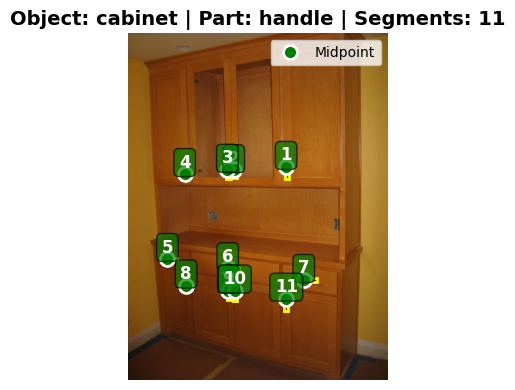

In [13]:
_ = visualize_mask_with_bboxes_and_midpoints(test_img_name, images_dir, masks_dir)

In [16]:
def process_all_images(images_dir, masks_dir, output_json_path):
    """
    Process all images and save their metadata to a JSON file.
    
    Args:
        images_dir: Directory containing the images
        masks_dir: Directory containing the masks
        output_json_path: Path to save the output JSON file
    
    Returns:
        data_list: List of dictionaries containing image metadata
    """
    data_list = []

    # image filenames
    image_names = os.listdir(images_dir)
    
    print(f"Processing {len(image_names)} images...")
    
    for image_name in tqdm(image_names):
        try:
            image_path = os.path.join(images_dir, image_name)
            image = Image.open(image_path)
            image_width, image_height = image.size
            
            # load mask and parse names
            mask, object_name, part_name = load_mask_and_parse_name(image_name, masks_dir)
            
            # bboxes and midpoints
            bboxes = get_bboxes_from_mask(mask)
            midpoints = get_bbox_midpoints(bboxes)
            deepest_mask_points = get_deepest_points(mask)
            
            # image_id - for instructpart, everything before the first hyphen from the end parts
            basename = os.path.splitext(image_name)[0]
            basename_parts = basename.split('-')
            image_id = basename_parts[0] # first part 
            
            data_entry = {
                "image_path": image_path,
                "image_name": image_name,
                "image_id": image_id,
                "object_name": object_name,
                "part_name": part_name,
                "bboxes": bboxes,
                "midpoints": midpoints,
                "image_width": image_width,
                "image_height": image_height,
                "num_segments": len(bboxes)
            }
            
            data_list.append(data_entry)
            
        except Exception as e:
            print(f"Error processing {image_name}: {e}")
            continue
    
    # Save to JSON file
    with open(output_json_path, 'w') as f:
        json.dump(data_list, f, indent=2)
    
    print(f"\nProcessed {len(data_list)} images successfully.")
    print(f"Data saved to: {output_json_path}")
    
    return data_list

In [17]:
# loop over all images and create a data structure to hold image paths and corresponding bboxes. Save in json file 
masks_dir = os.path.join(instructpart_train_dir, "masks")
images_dir = os.path.join(instructpart_train_dir, "images")
output_json = os.path.join('/data/VLMGroundingProject/Datasets/InstructPart/train1800', "instructpart_train_metadata_for_rl.json")

In [18]:
train_metadata_processed = process_all_images(images_dir, masks_dir, output_json)

Processing 1800 images...


100%|██████████| 1800/1800 [03:15<00:00,  9.21it/s]


Processed 1800 images successfully.
Data saved to: /data/VLMGroundingProject/Datasets/InstructPart/train1800/instructpart_train_metadata_for_rl.json


In [19]:
# create a smaller debug dataset with 32 samples 
debug_output_json = os.path.join('/data/VLMGroundingProject/Datasets/InstructPart/train1800', "instructpart_train_metadata_for_rl_debug32.json")
debug_metadata = train_metadata_processed[:32]

In [22]:
# Save to JSON file
with open(debug_output_json, 'w') as f:
    json.dump(debug_metadata, f, indent=2)

print(f"\nProcessed {len(debug_metadata)} images successfully.")
print(f"Data saved to: {debug_output_json}")


Processed 32 images successfully.
Data saved to: /data/VLMGroundingProject/Datasets/InstructPart/train1800/instructpart_train_metadata_for_rl_debug32.json


In [18]:
# statistics
print(f"Total images: {len(train_metadata_processed)}")
print(f"Total segments: {sum(d['num_segments'] for d in train_metadata_processed)}")
print(f"Average segments per image: {sum(d['num_segments'] for d in train_metadata_processed) / len(train_metadata_processed):.2f}")


Total images: 1800
Total segments: 2448
Average segments per image: 1.36


## Process in segzero/easyr1 format 

In [20]:
# format in segzero format 
from datasets import Dataset, DatasetDict, Image, Features, Value
from huggingface_hub import create_repo
import os
import json
from tqdm import tqdm
import glob
from tqdm import tqdm
from PIL import Image as PILImage
import cv2

/home/ksmehrab/miniconda/envs/segzero/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
def scale_box_coordinates(bbox_2d, x_factor, y_factor):
    """
    bbox_2d: [x1, y1, x2, y2]
    """

    scaled_bbox = [
        int(bbox_2d[0] * x_factor + 0.5),  # x1
        int(bbox_2d[1] * y_factor + 0.5),  # y1
        int(bbox_2d[2] * x_factor + 0.5),  # x2
        int(bbox_2d[3] * y_factor + 0.5)   # y2
    ]
    
    return scaled_bbox

def scale_point_coordinates(point_2d, x_factor, y_factor):
    """
    point_2d: [x, y]
    """
    scaled_point = [
        int(point_2d[0] * x_factor + 0.5),  # x
        int(point_2d[1] * y_factor + 0.5)   # y
    ]
    
    return scaled_point

def create_local_dataset(train_data, output_dir, image_resize):
    def process_split(split_data, image_resize):
        processed_data = split_data.copy()
        images = []
        for img_path in split_data['image']:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (image_resize, image_resize), interpolation=cv2.INTER_AREA)
            images.append(img)
        
        processed_data['image'] = images
        return processed_data
    
    dataset = DatasetDict({
        'train': Dataset.from_dict(
            process_split(train_data, image_resize),
            features=Features({
                'id': Value('string'),
                'problem': Value('string'),
                'solution': Value('string'),
                'image': Image(),
                'img_height': Value('int64'),
                'img_width': Value('int64'),
                'object_part': Value('bool')
            })
        )
    })
    
    dataset.save_to_disk(output_dir)
    print(f"saved to: {output_dir}")
    
    return dataset

In [23]:
data_path = "/data/VLMGroundingProject/Datasets/InstructPart/train1800/instructpart_train_metadata_for_rl.json"
data = json.load(open(data_path, 'r'))

image_resize = 840
    
id_list = []
problem_list = []
solution_list = []
image_list = []
img_height_list = []
img_width_list = []

"""
data_entry = {
    "image_path": image_path,
    "image_name": image_name,
    "image_id": image_id,
    "object_name": object_name,
    "part_name": part_name,
    "bboxes": bboxes,
    "midpoints": midpoints,
    "image_width": image_width,
    "image_height": image_height,
    "num_segments": len(bboxes)
}
"""

for idx, item in tqdm(enumerate(data)):
    id_list.append(item['image_id'])

    # construct problem string
    # e.g., "cabinet's handle" or "bus' wheel"
    if item['object_name'].strip().endswith('s'):
        problem = f"{item['object_name']}' {item['part_name']}"
    else:
        problem = f"{item['object_name']}'s {item['part_name']}"
    problem_list.append(problem)
    
    image_list.append(item['image_path'])
    
    # print(item['image_path'])
    image = cv2.imread(item['image_path'])
    height, width = image.shape[:2]
    
    img_height_list.append(height)
    img_width_list.append(width)
    
    x_factor = 840 / width
    y_factor = 840 / height
    solution = []

    # TODO: Does it have to be bboxes_2d and points_2d? How is Qwen_2_5 trained? What about Qwen3
    for box_idx in range(len(item['bboxes'])):
        solution.append({
            "bbox_2d": scale_box_coordinates(item['bboxes'][box_idx], x_factor, y_factor), # [x1, y1, x2, y2]
            "point_2d": scale_point_coordinates(item['midpoints'][box_idx], x_factor, y_factor) # [x, y]
            
        })
    solution_list.append(json.dumps(solution))
    # if idx > 20:
    #     break

# create an object_part_list. add True for all entries since this is instructpart dataset
object_part_list = [True] * len(id_list)

train_data = {
    'id': id_list,
    'problem': problem_list,
    'solution': solution_list,
    'image': image_list,
    'img_height': img_height_list,
    'img_width': img_width_list,
    'object_part': object_part_list
}

dataset = create_local_dataset(
    train_data=train_data,
    output_dir=f"/data/VLMGroundingProject/Datasets/InstructPart/train1800/instructpart_train_dataset_for_segzero_partfield_{image_resize}", 
    image_resize=image_resize
)

0it [00:00, ?it/s]

1800it [00:06, 267.09it/s]
Saving the dataset (3/3 shards): 100%|██████████| 1800/1800 [00:01<00:00, 1474.68 examples/s]

saved to: /data/VLMGroundingProject/Datasets/InstructPart/train1800/instructpart_train_dataset_for_segzero_partfield_840


In [23]:
# debug dataset with 32 samples
data_path = debug_output_json
data = json.load(open(data_path, 'r'))

image_resize = 840
    
id_list = []
problem_list = []
solution_list = []
image_list = []
img_height_list = []
img_width_list = []

"""
data_entry = {
    "image_path": image_path,
    "image_name": image_name,
    "image_id": image_id,
    "object_name": object_name,
    "part_name": part_name,
    "bboxes": bboxes,
    "midpoints": midpoints,
    "image_width": image_width,
    "image_height": image_height,
    "num_segments": len(bboxes)
}
"""

for idx, item in tqdm(enumerate(data)):
    id_list.append(item['image_id'])

    # construct problem string
    # e.g., "cabinet's handle" or "bus' wheel"
    if item['object_name'].strip().endswith('s'):
        problem = f"{item['object_name']}' {item['part_name']}"
    else:
        problem = f"{item['object_name']}'s {item['part_name']}"
    problem_list.append(problem)
    
    image_list.append(item['image_path'])
    
    # print(item['image_path'])
    image = cv2.imread(item['image_path'])
    height, width = image.shape[:2]
    
    img_height_list.append(height)
    img_width_list.append(width)
    
    x_factor = 840 / width
    y_factor = 840 / height
    solution = []

    # TODO: Does it have to be bboxes_2d and points_2d? How is Qwen_2_5 trained? What about Qwen3
    for box_idx in range(len(item['bboxes'])):
        solution.append({
            "bbox_2d": scale_box_coordinates(item['bboxes'][box_idx], x_factor, y_factor), # [x1, y1, x2, y2]
            "point_2d": scale_point_coordinates(item['midpoints'][box_idx], x_factor, y_factor) # [x, y]
            
        })
    solution_list.append(json.dumps(solution))
    # if idx > 20:
    #     break

# create an object_part_list. add True for all entries since this is instructpart dataset
object_part_list = [True] * len(id_list)

train_data = {
    'id': id_list,
    'problem': problem_list,
    'solution': solution_list,
    'image': image_list,
    'img_height': img_height_list,
    'img_width': img_width_list,
    'object_part': object_part_list
}

dataset = create_local_dataset(
    train_data=train_data,
    output_dir=f"/data/VLMGroundingProject/Datasets/InstructPart/train1800/instructpart_train_dataset_for_segzero_partfield_{image_resize}_debug32", 
    image_resize=image_resize
)

32it [00:00, 248.62it/s]
Saving the dataset (1/1 shards): 100%|██████████| 32/32 [00:00<00:00, 1294.95 examples/s]

saved to: /data/VLMGroundingProject/Datasets/InstructPart/train1800/instructpart_train_dataset_for_segzero_partfield_840_debug32
